In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px


c:\users\mrkoh\pycharmprojects\untitled1\venv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)

In [38]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]

In [39]:
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])

In [47]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]

In [48]:
df_countries_cases = df_countries_cases.drop(['country'],axis=1)
df_countries_cases.fillna(0,inplace=True)

In [49]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    plt.title( plt_title,{'fontsize':title_fsize})
    plt.yscale(scale)
    plt.minorticks_on()
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)

In [50]:
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        ax = f.add_subplot(figure[1],figure[2],figure[3])
        
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    

    if country != None:
        params = ["country",country]
    elif state != None:
        params = ["state",state]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')


    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    axis_label = ["Days","No of Cases"]
    
    plot_params(ax,axis_label,scale = scale)
    
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19: "+params[1] ,{'fontsize':25})

    l = plt.legend(loc= "best",fontsize = 10)
    if figure == None:
        plt.show()

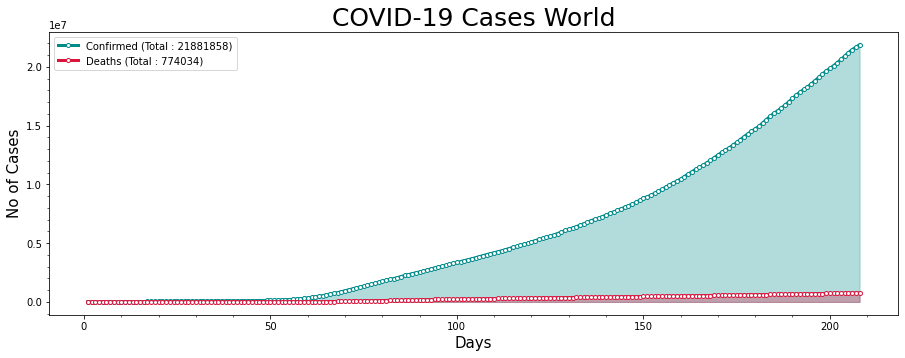

In [54]:
cols = 1
rows = 1
f = plt.figure(figsize=(15,7*rows))

visualize_covid_cases(df_confirmed, df_deaths,figure = [f,rows,cols, 1])

plt.show()

In [55]:
df_countries = df_confirmed.groupby(["country"]).sum()
df_countries = df_countries.sort_values(df_countries.columns[-1],ascending = False)
countries = df_countries[df_countries[df_countries.columns[-1]] >= 600].index

cols =2
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(20,8*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

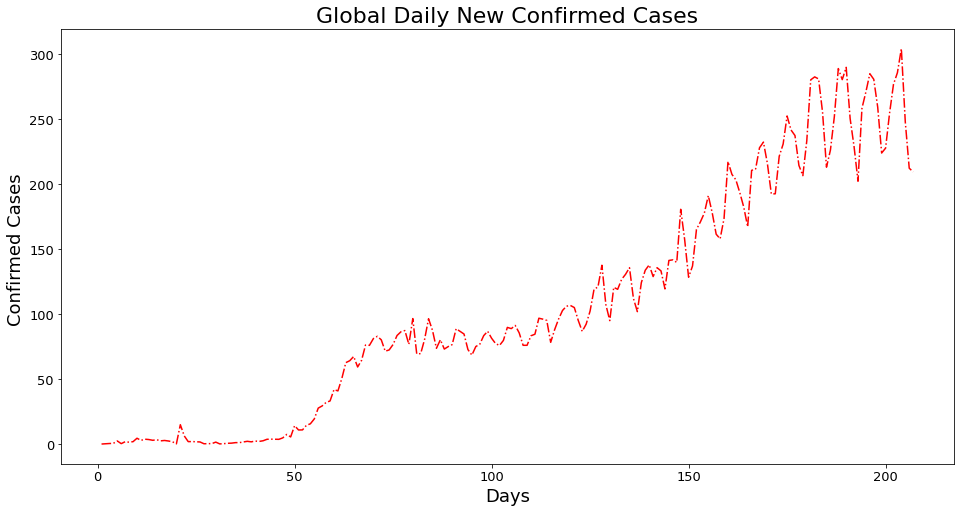

In [24]:
f = plt.figure(figsize=(16,8))
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())
date = np.arange(0,len(temp_data))
plt.plot(date,temp_data/1000,"-.",color="red")
plt.title("Global Daily New Confirmed Cases",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Confirmed Cases ",fontsize =18)
plt.tick_params(labelsize = 13) 
plt.show()

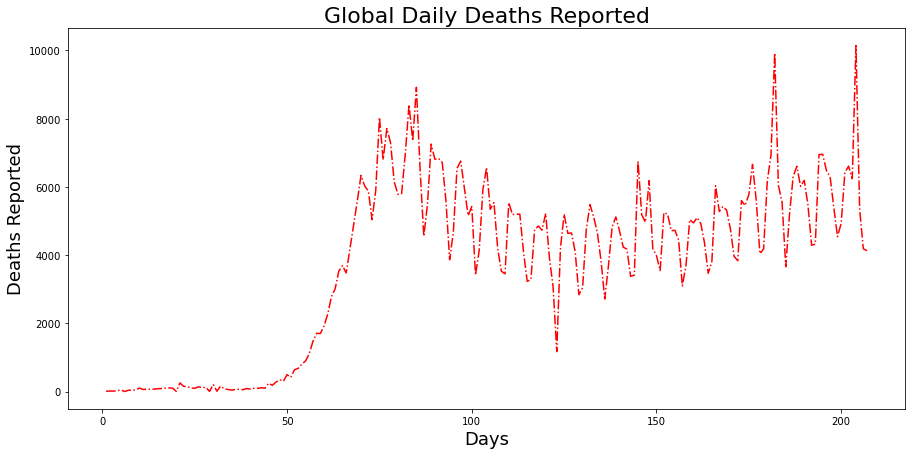

In [69]:
temp_data = df_deaths.sum()[5:].diff()
date = np.arange(0,len(temp_data))

f = plt.figure(figsize=(15,7))
plt.plot(date,temp_data,"-.",color="red")
plt.title("Global Daily Deaths Reported",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Deaths Reported",fontsize =18)
plt.show()

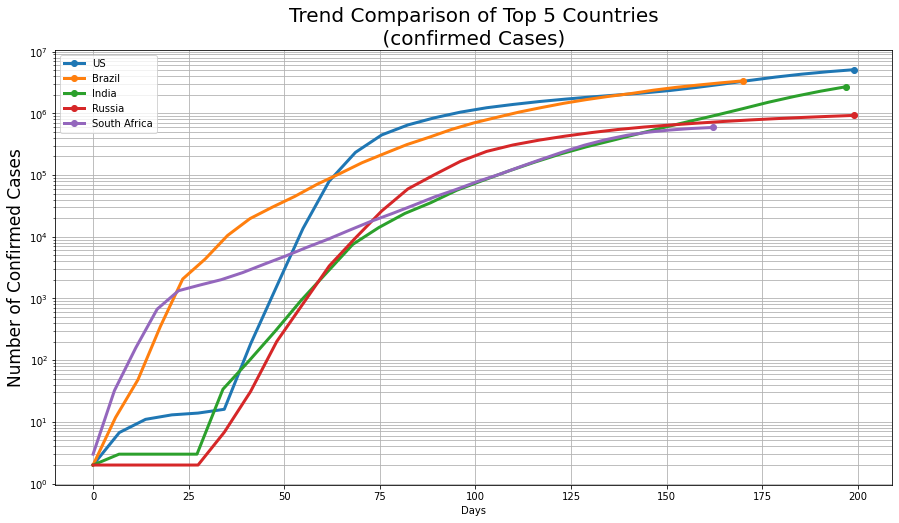

In [27]:
temp = df_confirmed.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 1
f = plt.figure(figsize=(15,8))

for i,country in enumerate(temp.index):
    if i >= 5:
        continue
    days = 200
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days] 
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 10)        
plt.xlabel("Days",fontsize=10)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Top 5 Countries\n (confirmed Cases) ",fontsize=20)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")

plt.show()

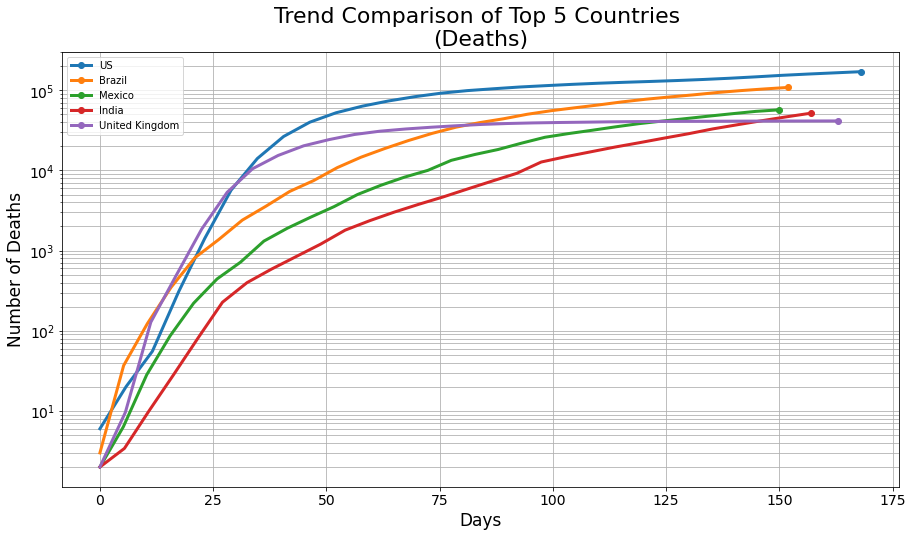

In [28]:
temp = df_deaths.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 1
f = plt.figure(figsize=(15,8))
for i,country in enumerate(temp.index):
    if i >= 5:
        break
    days = 200
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 14)        
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Top 5 Countries \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.show()

In [86]:
df_confirmed_can = pd.read_csv(r'D:\python\3335\untitled\Data\time_series_covid19_confirmed_Canada.csv')
df_deaths_can = pd.read_csv(r'D:\python\3335\untitled\Data\time_series_covid19_deaths_Canada.csv')

In [87]:
df_confirmed_can = df_confirmed_can.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths_can = df_deaths_can.rename(columns={"Province/State":"state","Country/Region": "country"})

In [88]:
df_confirmed_can.columns

Index(['state', 'country', 'Lat', 'Long', '1/22/20', '1/23/20', '1/24/20',
       '1/25/20', '1/26/20', '1/27/20',
       ...
       '08-02-2020', '08-03-2020', '08-04-2020', '08-05-2020', '08-06-2020',
       '08-07-2020', '08-08-2020', '08-09-2020', '08-10-2020', '08-11-2020'],
      dtype='object', length=207)

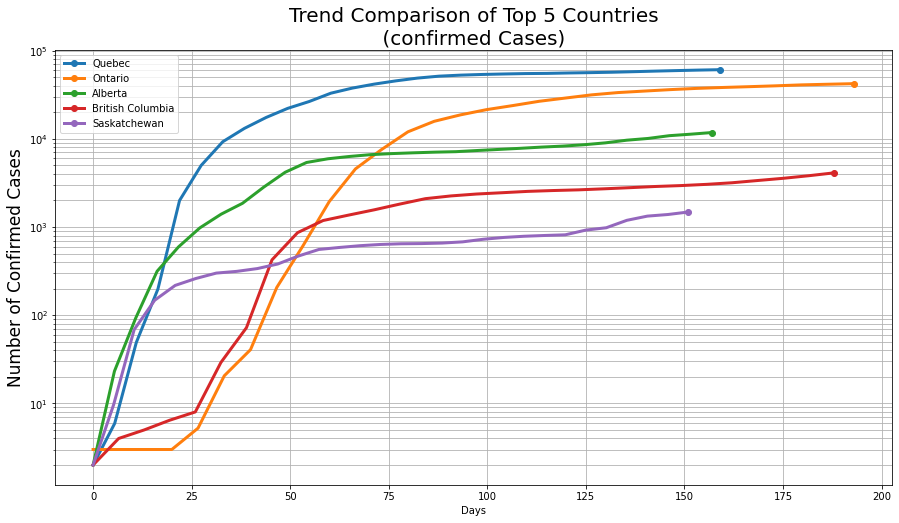

In [93]:
temp = df_confirmed_can.groupby('state').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed_can.columns[-1], ascending= False)

threshold = 1
f = plt.figure(figsize=(15,8))

for i,state in enumerate(temp.index):
    if i >= 5:
        continue
    days = 200
    t = temp.loc[temp.index == state].values[0]
    t = t[t>threshold][:days] 
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = state,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 10)        
plt.xlabel("Days",fontsize=10)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Top 5 Countries\n (confirmed Cases) ",fontsize=20)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")

plt.show()

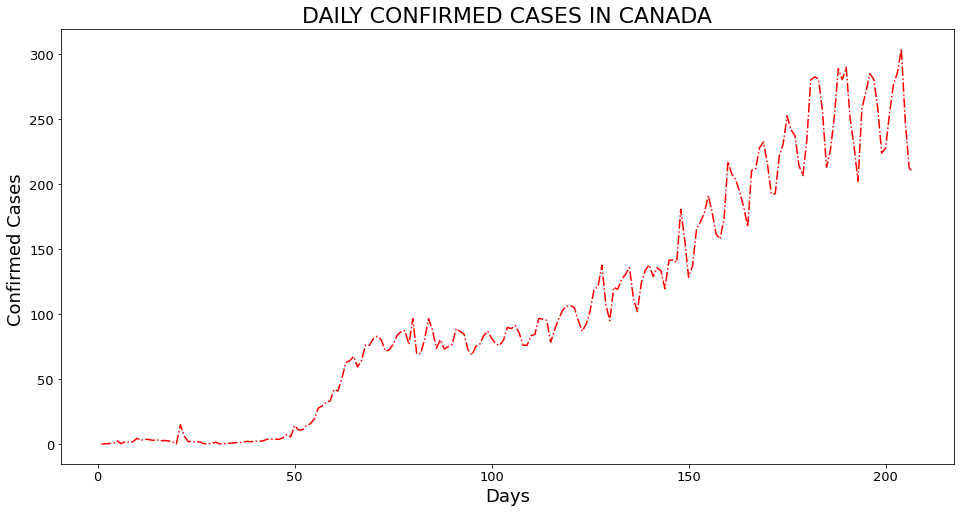

In [80]:
f = plt.figure(figsize=(16,8))
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())
date = np.arange(0,len(temp_data))
plt.plot(date,temp_data/1000,"-.",color="red")
plt.title("DAILY CONFIRMED CASES IN CANADA",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Confirmed Cases ",fontsize =18)
plt.tick_params(labelsize = 13) 
plt.show()

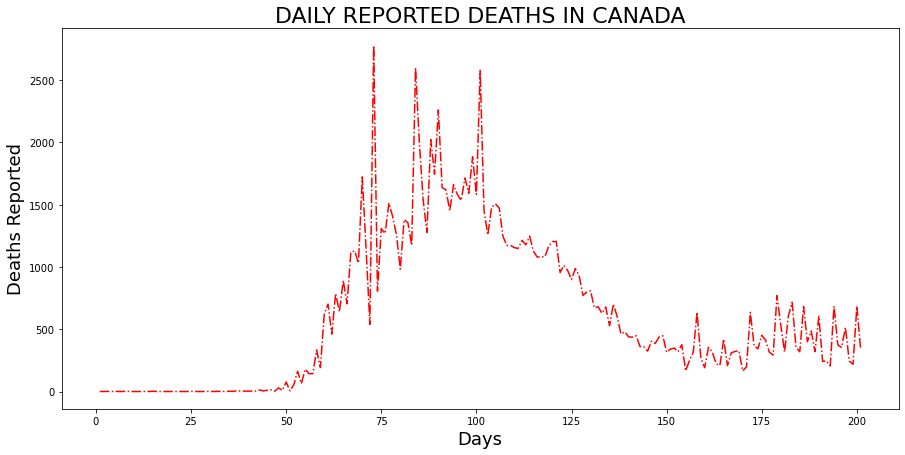

In [81]:
temp_data = df_confirmed_can.sum()[5:].diff()
date = np.arange(0,len(temp_data))

f = plt.figure(figsize=(15,7))
plt.plot(date,temp_data,"-.",color="red")
plt.title("DAILY REPORTED DEATHS IN CANADA",{'fontsize':22})
plt.xlabel("Days",fontsize =18)
plt.ylabel("Deaths Reported",fontsize =18)
plt.show()